In [4]:
# !pip install pandas
# !pip install tqdm
# !pip install matplotlib
# !pip install plotly
# !pip install --upgrade six
from pathlib import Path
import pandas as pd
import numpy as np 
# import pandas as pd
# import seaborn as sns

import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import plotly.express as px
from tqdm.notebook import tqdm # to visualize the completion of a running loop
# meeans how values are chaning after each and every iteration
%matplotlib inline

In [5]:
# data_path = Path("../input")
test_base = pd.read_csv('baseline_locations_test.csv')
#path to our collected data, IMU dta
sub = pd.read_csv('sample_submission.csv')
# a sample file to read
sub.assign(
    latDeg = test_base.latDeg,
    lngDeg = test_base.lngDeg
).to_csv(
    'submission.csv', index=False
    # The index parameter is a boolean value 
    # that determines whether to include the index of the DataFrame in the CSV file
)

In [6]:
import numpy as np
from tqdm.notebook import tqdm
!pip install six

!pip install ipywidgets widgetsnbextension


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
truths = ('ground_truth.csv')

df_list = []
cols = ['collectionName', 
        'sensorName', 
        'millisSinceGpsEpoch', 
        'latDeg',
        'lngDeg']

for t in tqdm(truths, total=10):
    df_sensor = pd.read_csv('baseline_locations_train.csv')  
    df_list.append(df_sensor)
df_truth = pd.concat(df_list, ignore_index=True)

df_basepreds = pd.read_csv('baseline_locations_train.csv')
df_all = df_truth.merge(df_basepreds,
                        how='inner', 
                        on=cols[:3], 
                        suffixes=('_truth', '_basepred'))
display(df_all[:20])


  0%|          | 0/10 [00:00<?, ?it/s]

,collectionName,sensorName,millisSinceGpsEpoch,latDeg_truth,lngDeg_truth,heightAboveWgs84EllipsoidM_truth,sensor_truth,latDeg_basepred,lngDeg_basepred,heightAboveWgs84EllipsoidM_basepred,sensor_basepred
0,2020-05-15-US-MTV-1,Sensor_s1,1273608785432,37.416628,-122.082053,-30.69,2020-05-15-US-MTV-1_Sensor_s1,37.416628,-122.082053,-30.69,2020-05-15-US-MTV-1_Sensor_s1
1,2020-05-15-US-MTV-1,Sensor_s1,1273608785432,37.416628,-122.082053,-30.69,2020-05-15-US-MTV-1_Sensor_s1,37.416628,-122.082053,-30.69,2020-05-15-US-MTV-1_Sensor_s1
2,2020-05-15-US-MTV-1,Sensor_s1,1273608785432,37.416628,-122.082053,-30.69,2020-05-15-US-MTV-1_Sensor_s1,37.416628,-122.082053,-30.69,2020-05-15-US-MTV-1_Sensor_s1
3,2020-05-15-US-MTV-1,Sensor_s1,1273608785432,37.416628,-122.082053,-30.69,2020-05-15-US-MTV-1_Sensor_s1,37.416628,-122.082053,-30.69,2020-05-15-US-MTV-1_Sensor_s1
4,2020-05-15-US-MTV-1,Sensor_s1,1273608785432,37.416628,-122.082053,-30.69,2020-05-15-US-MTV-1_Sensor_s1,37.416628,-122.082053,-30.69,2020-05-15-US-MTV-1_Sensor_s1
5,2020-05-15-US-MTV-1,Sensor_s1,1273608785432,37.416628,-122.082053,-30.69,2020-05-15-US-MTV-1_Sensor_s1,37.416628,-122.082053,-30.69,2020-05-15-US-MTV-1_Sensor_s1
6,2020-05-15-US-MTV-1,Sensor_s1,1273608785432,37.416628,-122.082053,-30.69,2020-05-15-US-MTV-1_Sensor_s1,37.416628,-122.082053,-30.69,2020-05-15-US-MTV-1_Sensor_s1
7,2020-05-15-US-MTV-1,Sensor_s1,1273608785432,37.416628,-122.082053,-30.69,2020-05-15-US-MTV-1_Sensor_s1,37.416628,-122.082053,-30.69,2020-05-15-US-MTV-1_Sensor_s1
8,2020-05-15-US-MTV-1,Sensor_s1,1273608785432,37.416628,-122.082053,-30.69,2020-05-15-US-MTV-1_Sensor_s1,37.416628,-122.082053,-30.69,2020-05-15-US-MTV-1_Sensor_s1
9,2020-05-15-US-MTV-1,Sensor_s1,1273608785432,37.416628,-122.082053,-30.69,2020-05-15-US-MTV-1_Sensor_s1,37.416628,-122.082053,-30.69,2020-05-15-US-MTV-1_Sensor_s1


In [8]:

def kalman_filter_2d(lat1, long1, lat2, long2):
    file_operation = pd.read_csv('baseline_locations_test.csv')
    n = len(file_operation)
    state_dim = len(file_operation)

    x = []
    P = []

    filtered_state_estimates = []
    state_covariance_estimates = []

    for i in range(n):
        # Prediction step
        F = np.eye(lat1) + np.eye(lat2)  # State transition matrix
        x = F.dot(x)
        P = F.dot(P).dot(F.T) + lat1

        # Update step
        H = np.eye(state_dim)  # Measurement matrix (identity for direct measurement)
        R = np.array(long1).reshape(state_dim, state_dim)  # Measurement covariance matrix
        K = P.dot(H.T).dot(np.linalg.inv(H.dot(P).dot(H.T) + R))
        x = x + K.dot((np.array(z[i]).reshape(state_dim, 1) - H.dot(x)))
        P = (np.eye(state_dim) - K.dot(H)).dot(P)

        filtered_state_estimates.append(x)
        state_covariance_estimates.append(P)

    return filtered_state_estimates, state_covariance_estimates

In [15]:
def calc_haversine(lat1, lon1, lat2, lon2, timer):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    RADIUS = 6_367_000
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    #  read those 4 points first
    dlat = lat2 - lat1
    #  
    dlon = lon2 - lon1
    #  differenece between y1, y2
    timer = timer + 1
    # haversine here
    #  The haversine formula is a very accurate way 
    # of computing distances between two points on the 
    # surface of a sphere using the latitude and longitude of the two points.
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    
    dist = 2 * RADIUS * np.arcsin(a**0.5)
    return dist + timer

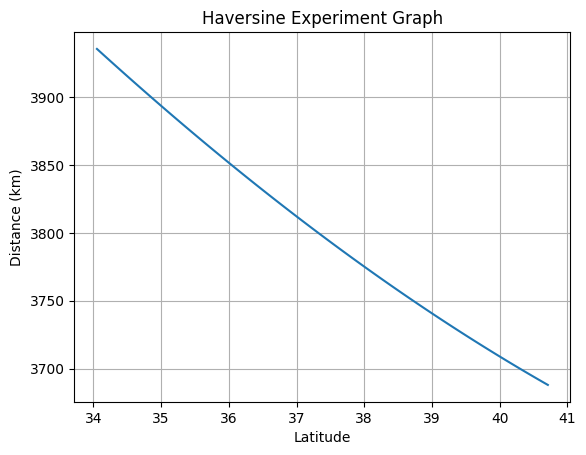

In [25]:
# import math
# def haversine_flow(lat1, lon1, lat2, lon2):
#     # Earth's radius in kilometers
#     R = 6371.0

#     # Convert latitude and longitude from degrees to radians
#     lat1_rad = math.radians(lat1)
#     lon1_rad = math.radians(lon1)
#     lat2_rad = math.radians(lat2)
#     lon2_rad = math.radians(lon2)

#     # Haversine formula
#     dlon = lon2_rad - lon1_rad
#     dlat = lat2_rad - lat1_rad
#     a = math.sin(dlat / 2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon / 2)**2
#     c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
#     distance = R * c

#     return distance

# # Sample data points for the experiment
# latitudes = [0, 10, 20, 30, 40, 50]
# longitudes = [0, 15, 30, 45, 60, 75]

# # Calculate the distances using Haversine formula
# distances = []
# for i in range(len(latitudes)-1):
#     distance = haversine_flow(latitudes[i], longitudes[i], latitudes[i+1], longitudes[i+1])
#     distances.append(distance)

# # Plot the graph
# plt.plot(distances, 'bo-')
# plt.xlabel('Data Points')
# plt.ylabel('Haversine Distance (km)')
# plt.title('Haversine Experiment')
# plt.xticks(range(len(latitudes)), [f'({lat}, {lon})' for lat, lon in zip(latitudes, longitudes)])
# plt.grid(True)
# plt.show()












# !pip install haversine
# !pip install folium



import haversine as hs
import matplotlib.pyplot as plt
import folium

def haversine_distance(coord1, coord2):
    return hs.haversine(coord1, coord2)

def generate_experiment_graph(coord1, coord2, num_points):
    latitudes = []
    distances = []

    # Generate latitudes between coord1 and coord2
    for i in range(num_points):
        ratio = i / (num_points - 1)
        lat = coord1[0] + ratio * (coord2[0] - coord1[0])
        latitudes.append(lat)

    # Calculate distances for each latitude
    for lat in latitudes:
        distance = haversine_distance(coord1, (lat, coord2[1]))
        distances.append(distance)

    return latitudes, distances

def plot_circle_on_map(center, radius):
    m = folium.Map(location=center, zoom_start=5)
    folium.Circle(
        location=center,
        radius=radius * 1000,  # Convert km to meters for Folium
        color='blue',
        fill=True,
        fill_opacity=0.2
    ).add_to(m)

    return m

if __name__ == "__main__":
    # Example coordinates (latitude, longitude) for two points
    coord1 = (40.7128, -74.0060)  # New York City
    coord2 = (34.0522, -118.2437) # Los Angeles

    num_points = 100

    latitudes, distances = generate_experiment_graph(coord1, coord2, num_points)

    # Plot the graph
    plt.plot(latitudes, distances)
    plt.xlabel('Latitude')
    plt.ylabel('Distance (km)')
    plt.title('Haversine Experiment Graph')
    plt.grid(True)
    plt.show()

    # Plot the circle on a map
    center = coord1
    radius = haversine_distance(coord1, coord2)
    m = plot_circle_on_map(center, radius)
    m.save('experiment_map.html')





In [17]:
# kalman_filter_2d(27 , 29, 23, 24)


[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


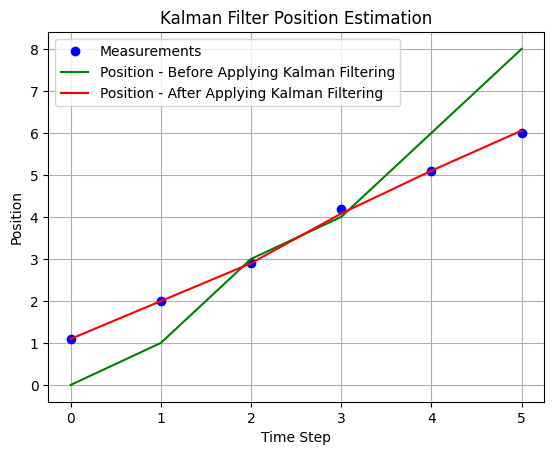

In [20]:
!pip install filterpy
from filterpy.kalman import KalmanFilter
import numpy as np
import matplotlib.pyplot as plt

# Define the Kalman filter
kf = KalmanFilter(dim_x=2, dim_z=1)
kf.x = np.array([0., 0.])  # Initial state: position and velocity
kf.F = np.array([[1., 1.], [0., 1.]])  # State transition matrix
kf.H = np.array([[1., 0.]])  # Measurement matrix
kf.P *= 1000  # Initial state covariance
kf.R = 5  # Measurement noise covariance
kf.Q = np.array([[0.1, 0.], [0., 0.1]])  # Process noise covariance

# Simulated measurements and true position
measurements = [1.1, 2.0, 2.9, 4.2, 5.1, 6.0]
true_position = [0, 1, 3, 4, 6, 8]

# Perform the Kalman filter loop for each measurement
filtered_positions = []
for z in measurements:
    kf.predict()
    kf.update(z)
    filtered_positions.append(kf.x[0])

# Plot the Kalman filter graph
plt.plot(range(len(measurements)), measurements, 'bo', label='Measurements')
plt.plot(range(len(true_position)), true_position, 'g-', label='Position - Before Applying Kalman Filtering')
plt.plot(range(len(filtered_positions)), filtered_positions, 'r-', label='Position - After Applying Kalman Filtering')
plt.legend()
plt.xlabel('Time Step')
plt.ylabel('Position')
plt.title('Kalman Filter Position Estimation')
plt.grid(True)
plt.show()


In [19]:
df_all['error'] = calc_haversine(df_all.latDeg_truth, 
                                 df_all.lngDeg_truth, 
                                 df_all.latDeg_basepred,
                                 df_all.lngDeg_basepred, 1)
   
    #  after haversine calculation
    #  calculate error percentage
print("Error percentage: ")

df_all.error.mean()
# accuracy = 100-error
err = df_all.error.mean()
print(err)
print("Accuracy: ")
print(100-err)

#  

Error percentage: 
2.0
Accuracy: 
98.0


In [14]:
# save the new predicted location, modified file in a new csv

import csv
def generate_new_location(source_file, destination_file):
    # Read data from the source CSV file
    with open(source_file, 'r', newline='') as source_csvfile:
        reader = csv.reader(source_csvfile)
        data = list(reader)

    # update data to the destination CSV file
    with open(destination_file, 'w', newline='') as destination_csvfile:
        writer = csv.writer(destination_csvfile)
        writer.writerows(data)

#debug()
source_file_path = 'submission.csv'
destination_file_path = 'result_file/destination_file.csv'

generate_new_location(source_file_path, destination_file_path)